# Nutria pyro model

In this notebook we'll tackle the same problem as in [nutria.ipynb](./nutria.ipynb) but instead of utilizing a pyfilter based inference algorithm we'll use pyro. As such, begin importing the data and then plot.

<AxesSubplot:title={'center':'Nutria population'}>

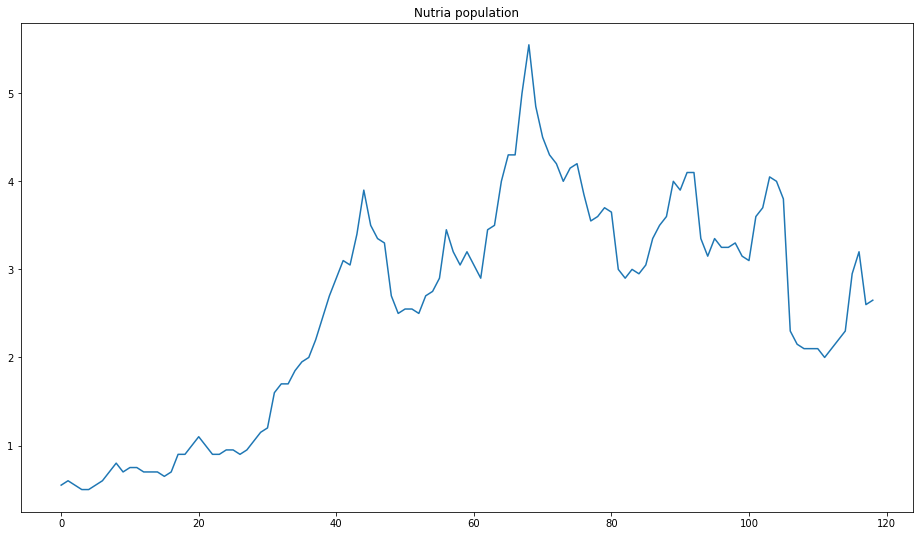

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (16, 9)

data = pd.read_csv("nutria.txt", sep="\t").iloc[:, 0].rename("nutria")
data.plot(figsize=(16, 9), title="Nutria population")

Next, let's define the model in [stoch-proc](https://github.com/tingiskhan/stoch-proc) format, utilizing the same model as in the previously mentioned notebook.

In [2]:
from stochproc import timeseries as ts, distributions as dists
from pyro.distributions import Normal, InverseGamma
import torch
from math import sqrt
from pyfilter.filters import particle


def f(x, a, b, c, sigma_e):
    exped = x.values.exp()
    return x.values + a + b * exped + c * exped ** 2, sigma_e.sqrt()


def build_obs(x, a, s):
    return Normal(loc=a * x.values, scale=s.sqrt())


def build_model(a, b, c, sigma_e, sigma_n):
    initial_dist = dists.DistributionModule(Normal, loc=0.0, scale=1.0)    
    inc_dist = dists.DistributionModule(Normal, loc=0.0, scale=1.0)
    
    hidden = ts.AffineProcess(f, (a, b, c, sigma_e), initial_dist=initial_dist, increment_dist=inc_dist)
    
    return ts.StateSpaceModel(hidden, build_obs, (1.0, sigma_n))


Now we'll perform the actual inference. For this problem we'll utilize the APF in order to perform smoothing and get a closed form expression for evaluating the log-likelihood w.r.t. the parameters of the model, which we'll target utilizing pyro.

In [3]:
import pyro
from pyro.infer import autoguide, SVI
from pyro.optim import Adam
from tqdm import tqdm


def pyro_model(y, only_params=False):
    a = pyro.sample("a", Normal(loc=0.0, scale=1.0)).unsqueeze(-1)
    b = pyro.sample("b", Normal(loc=0.0, scale=1.0)).unsqueeze(-1)
    c = pyro.sample("c", Normal(loc=0.0, scale=1.0)).unsqueeze(-1)
    
    alpha = y.shape[0] / 2.0
    beta = 2 * (alpha - 1.0) / 10.0     

    sigma_e = pyro.sample("sigma_e", InverseGamma(concentration=alpha, rate=beta)).unsqueeze(-1)
    sigma_n = pyro.sample("sigma_n", InverseGamma(concentration=alpha, rate=beta)).unsqueeze(-1)
    
    model = build_model(a, b, c, sigma_e, sigma_n)
    
    if only_params:
        return
    
    filt = particle.APF(model, 400, record_states=True)
    filt.set_batch_shape(a.shape[:-1])
    filt.do_sample_pyro(y, pyro)

    
guide = autoguide.AutoLowRankMultivariateNormal(pyro_model)
optim = Adam({"lr": 0.1})
svi = SVI(pyro_model, guide, optim, loss=pyro.infer.Trace_ELBO(num_particles=8, vectorize_particles=True))

pyro.clear_param_store()

y = torch.from_numpy(data.values).float().log()
running_avg = svi.step(y)

alpha = 0.98
niter = 500
bar = tqdm(range(niter), desc="Particle VI")

for n in bar:
    loss = svi.step(y)
    
    running_avg = alpha * running_avg + (1.0 - alpha) * loss    
    bar.set_postfix({"loss": f"{running_avg:.2f}"})

Particle VI: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [13:54<00:00,  1.67s/it, loss=70.06]


After performing the inference, we'll draw samples from the posterior distributions and get

In [4]:
from pyro.infer import Predictive


posterior_predictive = pyro.infer.Predictive(
    pyro_model,
    guide=guide,
    num_samples=1_000
)

samples = posterior_predictive(y, only_params=True)

Plotting with arviz yields

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma_e'}>,
        <AxesSubplot:title={'center':'sigma_n'}>, <AxesSubplot:>]],
      dtype=object)

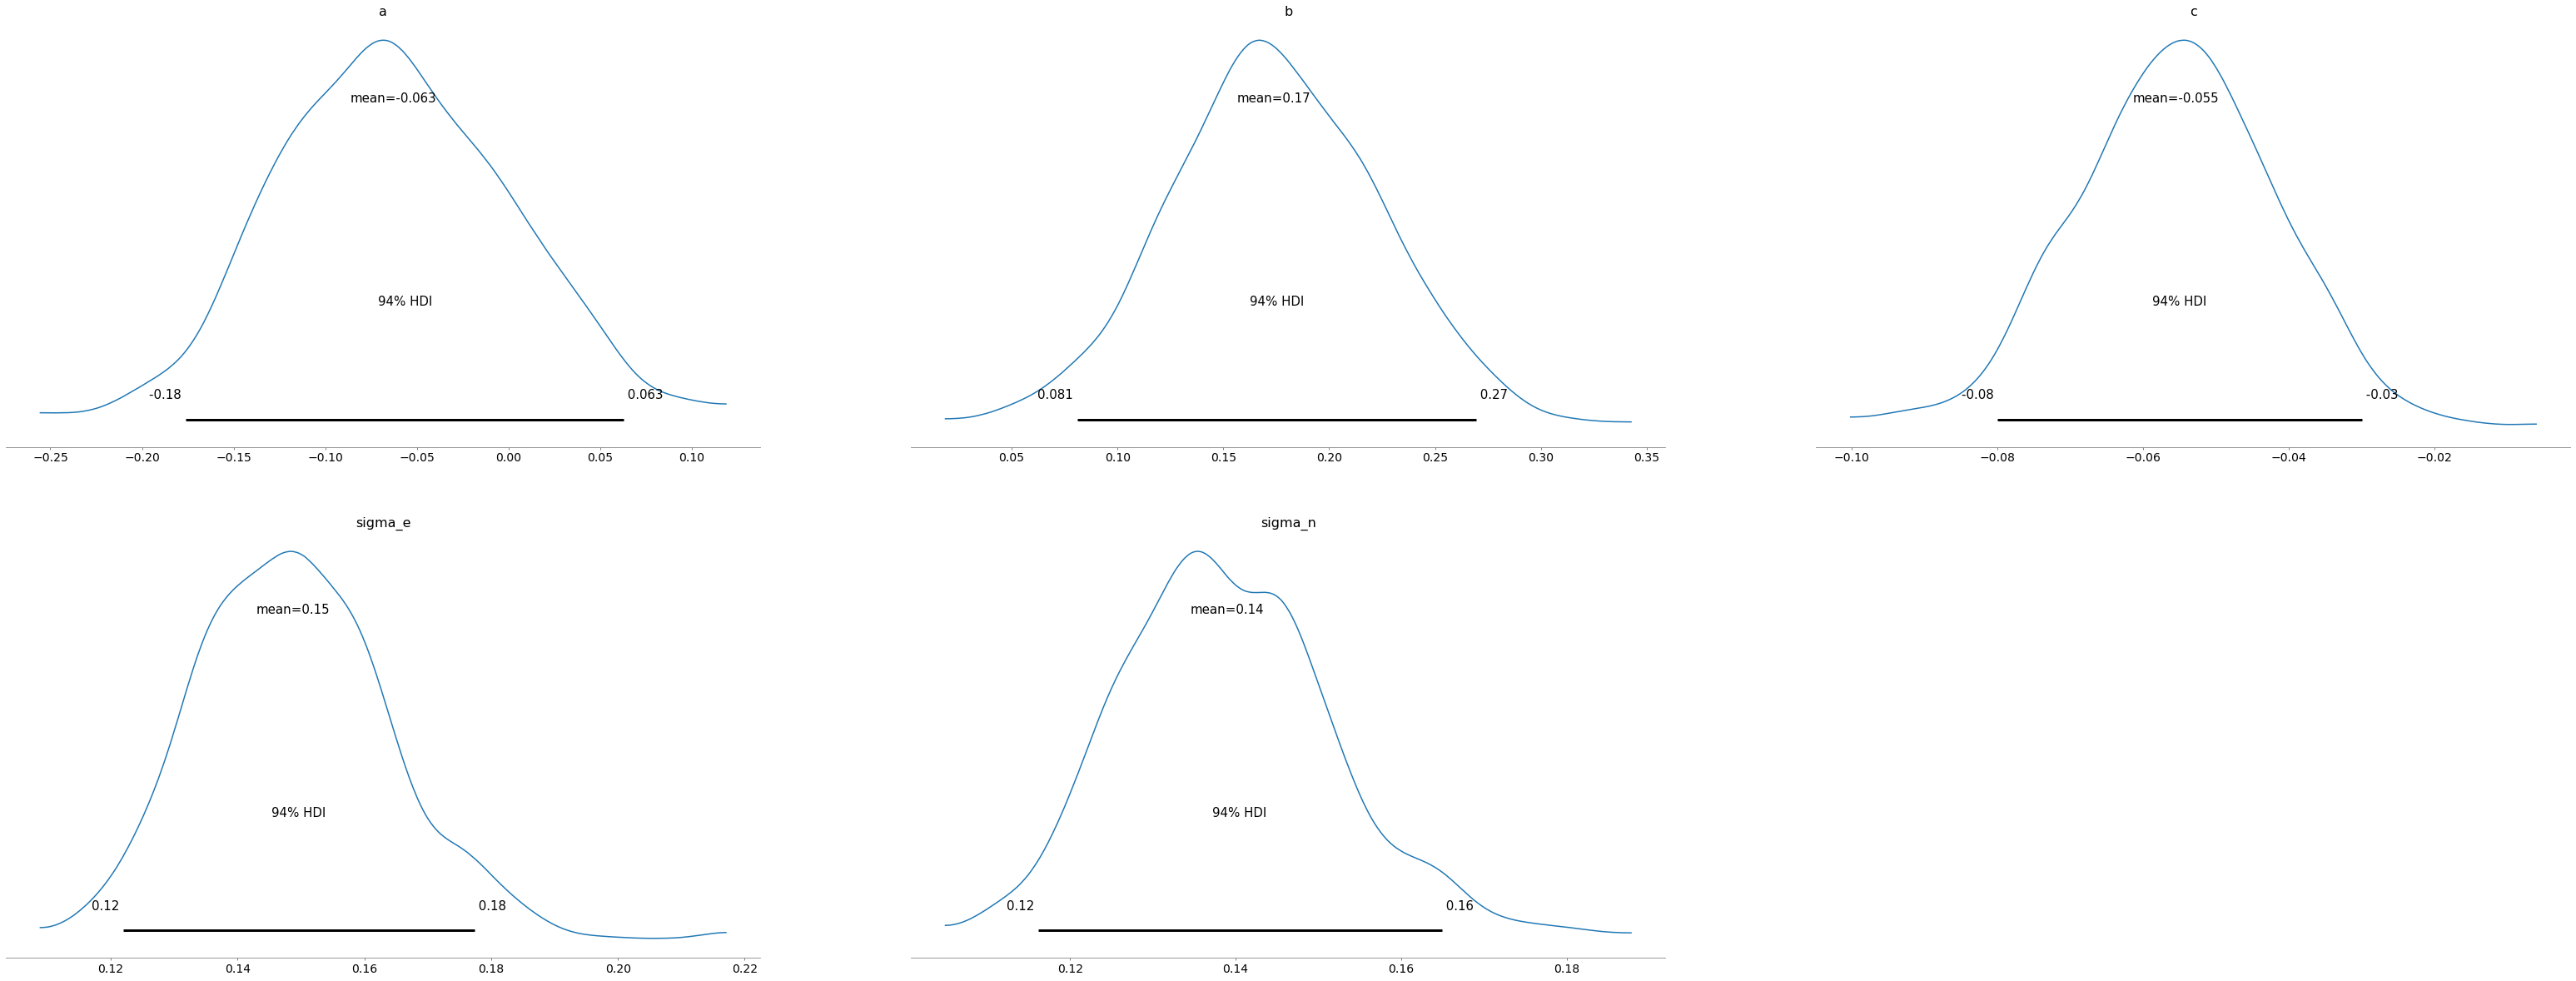

In [5]:
import arviz

posterior_draws = {k: v.unsqueeze(0) for k, v in samples.items()}

posteriors = arviz.from_dict(posterior_draws)

var_names = ["a", "b", "c", "sigma_e", "sigma_n"]
arviz.plot_posterior(posteriors, var_names=var_names)

Finally, we'll perform one filtering move utilizing the mean of the posterior distribution.

APF: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:01<00:00, 66.17it/s]


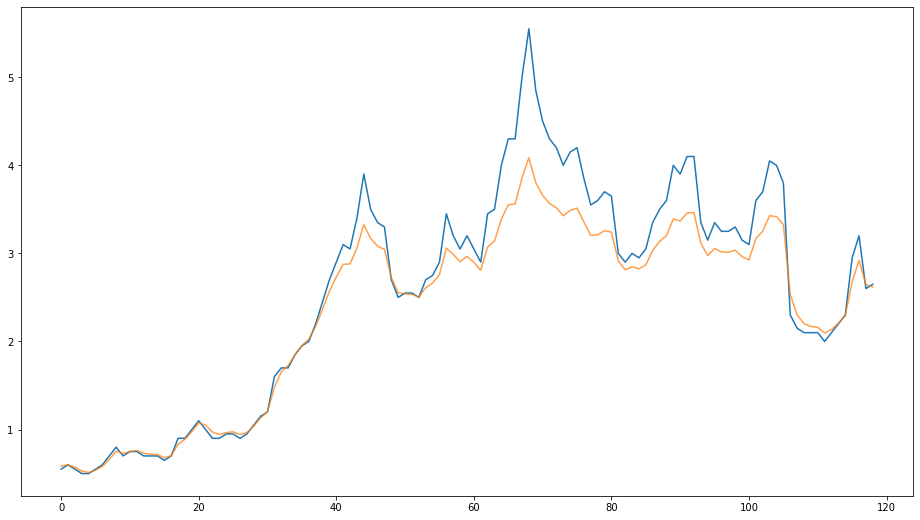

In [10]:
posterior_means = [posterior_draws[p].squeeze(0).unsqueeze(-1) for p in var_names]

mod = build_model(*posterior_means)

filt = particle.APF(mod, 250)
filt.set_batch_shape(posterior_means[0].shape[:-1])
result = filt.batch_filter(y)

fig, ax = plt.subplots()

ax.plot(y.exp())
ax.plot(result.filter_means[1:].mean(dim=1).exp(), alpha=0.75)

Comparing both parameter posteriors and states with those obtained in the [other notebook](./ipynb) we see that pyro and pyfilter have, in combination, backed out roughly the same the results.